# Implement Value at Risk & Conditional Value at Risk using:
# money money money 

    1. Historical Method
    2. Parametric Method (Variance-Covariance)
    3. Monte Carlo Method
     stochastic   arch garch ewma

## Get the Historical Data
First let's import the dependencies and get the data! 

## Get the Historical Data
First let's import the dependencies and get the data! 

In [1]:
## This is required for pandas_datareader on google colab - then you need to restart runtime
#!pip install --upgrade pandas_datareader
#!pip install arch


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt

In [3]:
# Import data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change(fill_method=None) # fill_method를 None으로 설정
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

import yfinance as yf
import numpy as np
import datetime as dt

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'STO']
stocks = [stock+'.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=8000)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns.dot(weights)


[*********************100%%**********************]  5 of 5 completed
/tmp/ipykernel_5606/4100175852.py:5: FutureWarning: The 'fill_method' and 'limit' keywords in DataFrame.pct_change are deprecated and will be removed in a future version. Call ffill before calling pct_change instead.
  returns = stockData.pct_change(fill_method=None) # fill_method를 None으로 설정


## Historical VaR

Here we make no assumptions about the distribution of returns.

In [4]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 100 days
Time = 252

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return:       494.71
Value at Risk 95th CI    :       2970.05
Conditional VaR 95th CI  :       4514.76


## Parametric VaR

Here we make an assumption on the distribution of returns abd use the historical portfolio returns and standard deviations (estimates) to define parameters for the model. Here we have implemented two parametric VaR models:
 - normal distribution
 - t-distribution (fatter tails)

In [5]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       2641.83
Normal CVaR 95th CI      :       3438.64
t-dist VaR 95th CI       :       2530.75
t-dist CVaR 95th CI      :       3616.84


## Monte Carlo VaR & CVaR
In this section we use a Monte Carlo simulation of a stock portfolio and then use the functions for historical VaR and CVaR to calculate our risk parameters.
The main advantage here is we could define individual models/stock dynamics for individual assets. This can be very powerful!

In [6]:
# Monte Carlo Method
mc_sims = 100 # number of simulations
T = 252 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

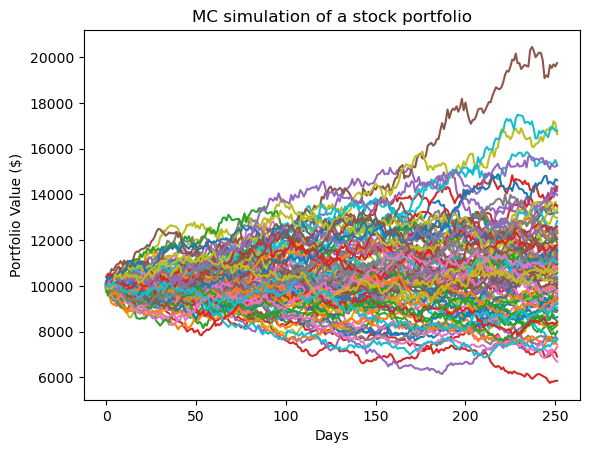

In [7]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [8]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [9]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $2358.47
CVaR $3150.95


## Comparison of each VaR & CVaR methods

In [10]:
print("\nVaR:")

print(' historical VaR 95th CI   :      ', round(InitialInvestment*hVaR,2))
print(" Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))
print(" Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 95th CI   :       2970.05
 Normal VaR 95th CI       :       2641.83
 t-dist VaR 95th CI       :       2530.75
 MC VaR  95th CI          :       2358.47

CVaR:
 historical CVaR 95th CI  :       4514.76
 Normal CVaR 95th CI      :       3438.64
 t-dist CVaR 95th CI      :       3616.84
 MC CVaR 95th CI          :       3150.95


In [11]:
import arch
import numpy as np
from scipy import stats
from arch import arch_model

# 로그 수익률을 계산하기 전에 0이나 음수 값이 있는지 확인합니다.
invalid_values = returns['portfolio'] <= 0
if invalid_values.any():
    print("Warning: the 'portfolio' column contains non-positive values")

# 로그 수익률을 계산합니다. 0이나 음수값이 있는 경우 np.nan을 반환합니다.
returns['log_return'] = np.where(~invalid_values, np.log(returns['portfolio'] / returns['portfolio'].shift(1)), np.nan)

# 누락된 값을 제거합니다.
returns.dropna(inplace=True)

# ARCH/GARCH 모델을 적합하기 위해 로그 수익률을 계산합니다.
returns['log_return'] = np.log(returns['portfolio'] / returns['portfolio'].shift(1))

# 누락된 값을 제거합니다.
returns.dropna(inplace=True)

# GARCH(1, 1) 모델을 적합합니다.
model = arch_model(returns['log_return'], vol='Garch', p=1, q=1)
model_fit = model.fit()

# 모델의 조건부 분산(conditional variance)을 계산합니다.
conditional_variances = model_fit.conditional_volatility

# 5% VaR을 계산합니다.
VaR_95 = -np.percentile(conditional_variances, 5)
print('VaR 95%: ', VaR_95)
from arch import arch_model

# 모델 설정
model_11 = arch_model(returns['log_return'], vol='Garch', p=1, q=1)
model_12 = arch_model(returns['log_return'], vol='Ewma', p=1, q=1)
model_13 = arch_model(returns['log_return'], vol='Arch', p=1, q=1)

# 모델 적합
model_11_fit = model_11.fit()
model_12_fit = model_12.fit()
model_13_fit = model_13.fit()

# VaR 95 계산
var_95_11 = -model_11_fit.conditional_volatility[-1] * stats.norm.ppf(1-0.05)
print('Garch VaR 95%: ', var_95_11)
var_95_12 = -model_12_fit.conditional_volatility[-1] * stats.norm.ppf(1-0.05)
print('EWMA VaR 95%: ', var_95_12)
var_95_13 = -model_13_fit.conditional_volatility[-1] * stats.norm.ppf(1-0.05)
print('ARCH VaR 95%: ', var_95_13)


ModuleNotFoundError: No module named 'arch'